In [15]:
import datetime
import cv2 as cv
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import firebase_admin
from firebase_admin import firestore
from google.cloud import bigquery, storage
from google.cloud.firestore_v1.base_query import FieldFilter
from google.cloud.firestore_v1 import ArrayUnion, Increment
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import tempfile
from pycontrails.datalib import goes

Query everything under GOES (roughly)
```
SELECT DISTINCT id FROM `contrails-301217.workshop_observerapp.image_field_of_view` WHERE ST_INTERSECTSBOX(geometry, -157, -81.3, 6.3, 81.3) IS TRUE LIMIT 1000
```

In [18]:
goes_handler = goes.GOES(goes.GOESRegion.F)
client = bigquery.Client()
storage_client = storage.Client("contrails-observer")
bucket = storage_client.get_bucket("contrails-observer.appspot.com")
photo_id = 'kaSHwzAPBfw3NVX15fzo'

In [5]:
# Get photo polygons from big query
QUERY = (
    'SELECT timestamp, latitude, longitude, id FROM `contrails-301217.workshop_observerapp.image_metadata`'
    f'WHERE id = "{photo_id}"')
query_job = client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish
ra = list(rows)
assert len(ra) == 1
dt = ra[0].timestamp
latitude = ra[0].latitude
longitude = ra[0].longitude

In [7]:
# Round time up to ten minute interval so it falls on a GOES frame
dt = dt + datetime.timedelta(minutes=10) - datetime.timedelta(minutes=dt.minute % 10, seconds=dt.second,microseconds=dt.microsecond)
tstr = dt.strftime('%Y-%m-%d %H:%M:00')

In [8]:
# Get GOES image and transform info
da = goes_handler.get(tstr)
rgb, src_crs, src_extent = goes.extract_goes_visualization(da, color_scheme="ash")

In [9]:
# Get photo polygons from big query
QUERY = (
    'SELECT geometry, id, level FROM `contrails-301217.workshop_observerapp.image_field_of_view`'
    f'WHERE id = "{photo_id}" '
    'LIMIT 100')
query_job = client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish

polygons = {}
for row in rows:
    polygons[row.level] = row.geometry

# Parse out coordinates of largest polygon
coords_str = [p.split(' ') for p in polygons[440][9:-2].split(', ')]
coords = [[float(lon), float(lat)] for (lon, lat) in coords_str]

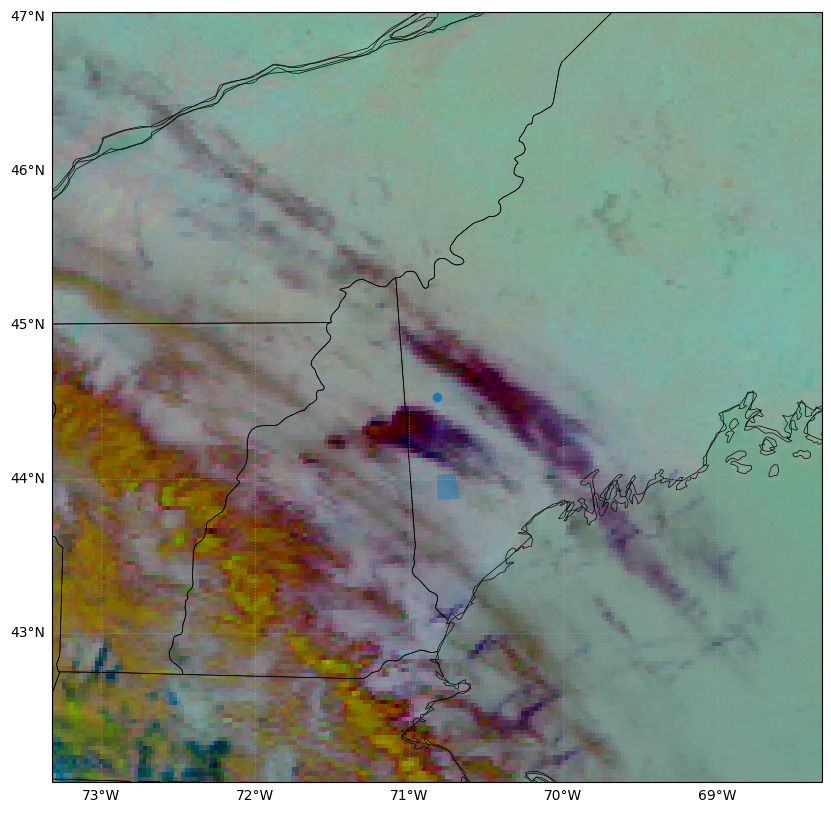

In [10]:
# Now plot everything
dst_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=dst_crs, extent=(longitude-2.5, longitude+2.5, latitude-2.5, latitude+2.5))

ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.5)

ax.imshow(rgb, extent=src_extent, transform=src_crs, origin="upper", interpolation="none")
ax.scatter(longitude, latitude)
ax.add_patch(mpatches.Polygon(xy=coords, alpha=0.5, transform=dst_crs))
# Set the x and y ticks to use latitude and longitude labels
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle=":")
gl.top_labels = False
gl.right_labels = False

Premature end of JPEG file


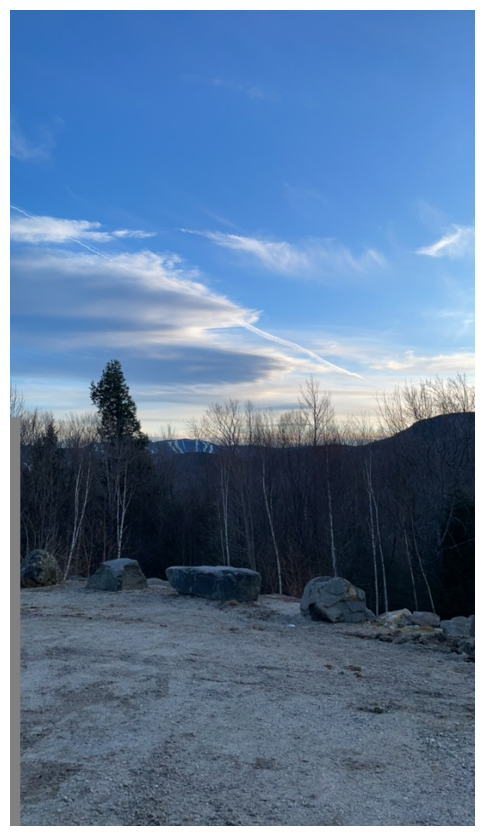

In [24]:
with tempfile.NamedTemporaryFile() as tmp:
    blob = bucket.blob(photo_id)
    blob.download_to_file(tmp)
    fig, ax = plt.subplots(1,figsize=(6,10.6))
    img_color = cv.imread(tmp.name)
    ax.imshow(img_color[...,::-1],aspect='auto')
    ax.set_axis_off()